'ForwardSelection_v0.ipynb' 코드에서 성능 개선되지 않으면 중단 -> **3번 이상 개선되지 않으면 중단** 하는 조건으로 수정했습니다.



---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 작업 디렉토리 변경
import os
print(os.getcwd(), end=' -> ')
os.chdir('/content/drive/MyDrive/PatternRecognition/project')
print(os.getcwd())

/content -> /content/drive/MyDrive/PatternRecognition/project


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# CSV 파일 불러오기
df = pd.read_csv('train.csv')
df.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,shares,y
0,17335,9.0,409.0,0.501326,1.0,0.587361,23.0,2.0,11.0,0.0,...,-0.1875,-0.1,0.50,0.500,0.00,0.500,Lifestyle,NaN,801,0
1,21242,10.0,317.0,0.725086,1.0,0.830097,6.0,3.0,NaN,21.0,...,-0.6000,NaN,0.00,0.000,0.50,0.000,Lifestyle,Tuesday,426,0
2,9448,11.0,447.0,0.584091,1.0,0.730104,NaN,1.0,1.0,1.0,...,-0.5000,-0.1,0.75,0.125,0.25,0.125,World,Friday,2400,1
3,36797,13.0,143.0,0.638298,NaN,0.787500,3.0,2.0,NaN,0.0,...,0.0000,0.0,1.00,NaN,0.50,0.500,Social Media,NaN,1100,0
4,29504,17.0,576.0,0.524412,1.0,0.714286,8.0,3.0,NaN,0.0,...,-1.0000,-0.1,0.00,0.000,0.50,0.000,World,Wednesday,1500,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            22200 non-null  int64  
 1   n_tokens_title                20000 non-null  float64
 2   n_tokens_content              20054 non-null  float64
 3   n_unique_tokens               19942 non-null  float64
 4   n_non_stop_words              20017 non-null  float64
 5   n_non_stop_unique_tokens      19944 non-null  float64
 6   num_hrefs                     19967 non-null  float64
 7   num_self_hrefs                19920 non-null  float64
 8   num_imgs                      19986 non-null  float64
 9   num_videos                    19906 non-null  float64
 10  average_token_length          19987 non-null  float64
 11  num_keywords                  19955 non-null  float64
 12  kw_min_min                    19984 non-null  float64
 13  k

(0.0, 20000.0)

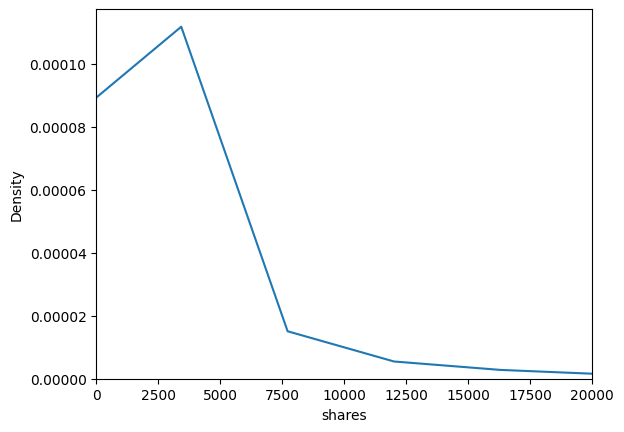

In [5]:
# 공유 수 분포 그래프
sns.kdeplot(df['shares'])
plt.xlim(0, 20000)

# **데이터 전처리**

In [6]:
# 가장 많이 등장한 값이 전체에서 차지하는 비율 top 10
top_ratio_dict = {}

for col in df.columns:
    most_common = df[col].value_counts(dropna=False).iloc[0]
    total = len(df)
    ratio = most_common / total
    top_ratio_dict[col] = ratio

top_10 = sorted(top_ratio_dict.items(), key=lambda x: x[1], reverse=True)[:10]

for col, ratio in top_10:
    print(f"{col}: {ratio:.2%}")

kw_max_max: 68.41%
num_videos: 56.30%
kw_min_min: 51.76%
y: 50.43%
abs_title_subjectivity: 46.68%
title_sentiment_polarity: 45.55%
abs_title_sentiment_polarity: 45.47%
num_imgs: 41.08%
title_subjectivity: 40.79%
kw_min_avg: 39.03%


In [7]:
# 중복 값이 많은 변수들을 자세히 살펴보자
df['kw_min_min'].value_counts(dropna=False).head(5)

,count
kw_min_min,
-1.0,11491
4.0,6074
217.0,2367
NaN,2216
0.0,34


In [8]:
df['kw_max_max'].value_counts(dropna=False).head(5)

,count
kw_max_max,
843300.0,15186
NaN,2232
690400.0,2017
617900.0,1143
69100.0,654


In [9]:
df['n_non_stop_words_rounded'] = df['n_non_stop_words'].round(3)  # 소수 셋째 자리까지 반올림
df['n_non_stop_words_rounded'].value_counts(dropna=False)

,count
n_non_stop_words_rounded,
1.0,19420
NaN,2183
0.0,597


In [10]:
# 많은 값들이 같은 값을 가지므로 삭제한다
df.drop(columns=['kw_min_min'], axis=1, inplace=True)
df.drop(columns=['kw_max_max'], axis=1, inplace=True)
df.drop(columns=['n_non_stop_words'], axis=1, inplace=True)

In [11]:
# 반올림 값을 확인하기 위해 만들었던 n_non_stop_words_rounded도 삭제
df.drop(columns=['n_non_stop_words_rounded'], axis=1, inplace=True)

In [12]:
# 'id'는 학습에 사용할 값이 아니므로 삭제한다
df.drop(columns=['id'], axis=1, inplace=True)

In [13]:
# 요일별 shares의 평균, 최댓값, 최솟값
weekday_stats = df.groupby('weekday')['shares'].agg(
    avg_shares=lambda x: round(x.mean(), 2),
    max_shares='max',
    min_shares='min'
).reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['weekday'] = pd.Categorical(weekday_stats['weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('weekday')
print(weekday_stats)

     weekday  avg_shares  max_shares  min_shares
1     Monday     3574.82      652900          43
5    Tuesday     3139.31      208300          42
6  Wednesday     3432.23      843300          48
4   Thursday     3225.35      298400          22
0     Friday     3152.97      233400          28
2   Saturday     4544.41      617900          49
3     Sunday     3937.87       83300         171


In [14]:
# 결측치 처리
for col in df.columns:
    if df[col].dtype == 'object': # 범주형 → 최빈값
        df[col].fillna(df[col].mode()[0], inplace=True)
    else: # 숫자형 → 중간값
        df[col].fillna(df[col].median(), inplace=True)

<ipython-input-14-6a0114ce1937>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-14-6a0114ce1937>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [15]:
# is_weekend 변수 추가
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# 범주형 데이터 One-Hot Encoding
df = pd.get_dummies(df, columns=['data_channel', 'weekday'], drop_first=True)

In [16]:
# 입력 변수(X), 라벨(y) 분리
X = df.drop(columns=['shares', 'y'])
y = np.log1p(df['shares'])  # log(1 + shares) -> shares=0 일 경우 에러 방지

# 정규화
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# train, val set을 나눈 뒤에 정규화 진행해보자.

# **Forward Selection**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

## 정규화

In [18]:
# PCA 중요도 순서대로 feature가 담긴 list 저장
# ("preprocessing_v0_modified.ipynb" 마지막 셀의 출력 결과 복사, 붙여넣기)
important_features_ranked_index = [
 'data_channel_Lifestyle',
 'kw_avg_max',
 'global_rate_positive_words',
 'kw_min_avg',
 'data_channel_World',
 'min_positive_polarity',
 'LDA_00',
 'min_negative_polarity',
 'num_hrefs',
 'LDA_02',
 'global_rate_negative_words',
 'self_reference_min_shares',
 'num_keywords',
 'data_channel_Tech',
 'LDA_01',
 'kw_max_avg',
 'self_reference_max_shares',
 'LDA_04',
 'LDA_03',
 'num_self_hrefs',
 'kw_max_min',
 'num_videos',
 'abs_title_sentiment_polarity',
 'rate_positive_words',
 'num_imgs',
 'global_sentiment_polarity',
 'kw_min_max',
 'self_reference_avg_sharess',
 'data_channel_Entertainment',
 'max_negative_polarity',
 'average_token_length',
 'title_subjectivity',
 'data_channel_Social Media',
 'abs_title_subjectivity',
 'kw_avg_min',
 'n_non_stop_unique_tokens',
 'kw_avg_avg',
 'avg_negative_polarity',
 'rate_negative_words',
 'max_positive_polarity',
 'n_tokens_title',
 'n_unique_tokens',
 'avg_positive_polarity',
 'n_tokens_content',
 'title_sentiment_polarity',
 'weekday_Saturday',
 'weekday_Sunday',
 'is_weekend',
 'global_subjectivity',
 'weekday_Thursday',
 'weekday_Monday',
 'weekday_Tuesday',
 'weekday_Wednesday']

In [19]:
# train, val set 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [20]:
# 정규화
scaler = StandardScaler()

# 학습 데이터에 scaler를 fit, transform
X_train_scaled_array = scaler.fit_transform(X_train)
# list를 이용해 feature을 선택할 수 있게끔 하기 위해서 pandas DataFrame으로 수정
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=important_features_ranked_index, index=X_train.index)

# 학습 데이터에 맞게 fit된 scaler로 검증 데이터를 transform
X_val_scaled_array = scaler.transform(X_val)
# list를 이용해 feature을 선택할 수 있게끔 하기 위해서 pandas DataFrame으로 수정
X_val_scaled = pd.DataFrame(X_val_scaled_array, columns=important_features_ranked_index, index=X_val.index)

## 함수 정의

#### **fixed_optional_split**: 고정 리스트와 선택 리스트 만들기

PCA 중요도 순위에서 몇 순위까지 고정하고 싶은지 바꾸고 싶을 때 사용한다. <br>
forward 함수를 호출하기 전에 사용해서, <br>
이 함수의 리턴값을 저장해서(fixed_features, optional_features) forward에 인수로 넣어주면 된다.

In [21]:
# 고정 리스트와 선택 리스트 만드는 함수 정의
def fixed_optional_split(fixed_num):
    # 고정된 리스트: 고정 개수만큼, PCA 중요도 순서대로 저장
    fixed = important_features_ranked_index[:fixed_num]

    # 선택을 위한 리스트: 나머지를 저장
    optional = important_features_ranked_index[fixed_num:]

    return fixed, optional

In [22]:
fixed_features = []
optional_features = []

In [23]:
# 다음과 같이 사용
fixed_features, optional_features = fixed_optional_split(20)

In [24]:
# 잘 들어갔는지 확인해보는 코드
fixed_features == important_features_ranked_index[:20]

True

#### **adjusted_r2**: Adjusted R^2를 계산하기

RidgePerf(성능 지표를 리턴하는 함수)의 내부에서 사용할 함수. <br>
- R2: R2 값 <br>
- N: number of examples (of validation set) (즉, 행의 수) <br>
- P: number of input variables(features) (of validation set) (즉, 열의 수)

In [25]:
# R2값을 이용해 Adjusted R2를 계산하는 함수 adjusted_r2 정의
def adjusted_r2(R2, N, P):
    return 1 - (((1 - R2) * (N - 1)) / (N - P - 1))

#### **RidgePerf**: Ridge regression 모델을 학습시키고 성능 지표(Adjusted R2)를 리턴 받기

train과 validation set을 인수로 주면, Adjusted R2 값을 리턴하는 함수. <br>
- sklearn.linear_model 에서 import한 Ridge를 사용. <br>
- alpha는 1을 사용. (결정 과정은 아래 'Ridge 파라미터(alpha) 값 테스트'부분 참고)
- 나머지 인수들은 기본값.
- sklearn.metrics에서 import한 r2_score과, 위에서 정의한 adjusted_r2 함수를 사용.

In [26]:
# Ridge 모델을 학습시키고 Adjusted R2 성능 지표를 리턴하는 함수 RidgePerf 정의
def RidgePerf(X_tr, X_vl, y_tr, y_vl, alpha=1):
    model = Ridge(alpha = alpha)
    model.fit(X_tr, y_tr)
    y_predict = model.predict(X_vl)
    r2 = r2_score(y_vl, y_predict)
    r2_adj = adjusted_r2(r2, X_vl.shape[0], X_vl.shape[1])
    # 성능 지표로 Adjusted R2 사용
    metric = r2_adj
    return metric

#### **forward**: forward selection을 수행하기

In [41]:
no_improvement_count = 0
# 인수로 train set과 validation set, fixed_list(고정하고 싶은 feature 이름들), optional_list(하나씩 선택하고 싶은 feature 이름들)를 받는다.
# 이때 X_trn과 X_vld는 열 이름을 가진 판다스 데이터프레임이어야 한다. (feature를 일부만 선택하는 데에 열 이름을 담은 리스트를 사용하기 때문)
def forward(X_trn, X_vld, y_trn, y_vld, fixed_list, optional_list, alpha=1):
    print(f"고정 개수: {len(fixed_list)}")
    print(f"fixed_list: {fixed_list}")

    # fixed_list로만 학습한 성능 저장
    fixed_perf = RidgePerf(X_trn[fixed_list], X_vld[fixed_list], y_trn, y_vld, alpha=alpha)
    print(f"fixed_perf: {fixed_perf}")

    # 반복 및 성능 비교 시 사용할 변수 초기화
    test_list = fixed_list.copy()               # 성능을 테스트할 subset을 담을 test_list
    results = {}                                # 각 subset들의 성능을 담을 딕셔너리 results
    final_fixed_list = fixed_list.copy()        # 다음 forward 함수에 넘겨줄 고정 feature들이 담긴 리스트.
    final_optional_list = optional_list.copy()  # 다음 forward 함수에 넘겨줄 후보군 feature들이 담긴 리스트.

    global no_improvement_count    # 성능 개선되지 않은 횟수 저장

    # optional_list의 feature 이름을 하나씩 골라 추가하며 각각의 성능을 results에 저장
    for i in range(len(optional_list)):

        # test_list에 optional_list의 i번째 feature 이름을 추가
        test_list.append(optional_list[i])

        # 성능을 results 딕셔너리에 추가.
        # 이때 key는 optional_list의 i번째 feature 이름이고, value는 test(fixed + 선택된 feature)_list를 이용한 성능이다.
        test_list_perf = RidgePerf(X_trn[test_list],
                                   X_vld[test_list],
                                   y_trn,
                                   y_vld,
                                   alpha=alpha)
        results[optional_list[i]] = test_list_perf
        # print(f"tested feature: {optional_list[i]} / test_list_perf: {test_list_perf}")

        # 다음 반복을 위해 test_list에 append했던 optional_list[i]를 제거 (즉, 마지막 값을 제거)
        test_list.pop()

    # 성능 비교
    best_optional_feature = max(results, key=results.get)
    best_optional_perf = results[best_optional_feature]
    if fixed_perf <= best_optional_perf:
        # fixed_list의 성능보다 낫거나 같은 성능을 내는 subset이 있을 때
        # (주의: metric이 클수록 성능이 좋다는 가정 하에 작동)
        # (성능이 그대로일 때에도 다음 forward selection을 진행함)
        print("성능 개선.", f"best_optional_feature: {best_optional_feature}", "//", f"best_optional_perf: {best_optional_perf}")

        # 다음 forward 함수 호출에 넣어줄 리스트들을 업데이트.
        final_fixed_list.append(best_optional_feature)
        final_optional_list.remove(best_optional_feature)

        no_improvement_count = 0

        # forward(자기자신)를 호출. if문의 조건이 만족되지 않을 때까지 재귀적으로 호출된다.
        return forward(X_trn, X_vld, y_trn, y_vld, final_fixed_list, final_optional_list)


    else:
        if no_improvement_count >= 3:

            print("3회 이상 성능 개선 불가하여 멈춤.")
            print(f"number of features: {len(final_fixed_list)}")
            print(f"fixed_perf: {fixed_perf} / best_optional_perf: {best_optional_perf}")
            # feature를 추가했을 때 성능이 더 떨어졌다면 추가하지 않은 리스트를 리턴.
            # 인수로 들어온 fixed_list를 그대로 호출하는 것과 같음.
            return final_fixed_list, fixed_perf
        else:
            print("성능 개선 불가 1회 추가")
            no_improvement_count += 1
            return forward(X_trn, X_vld, y_trn, y_vld, final_fixed_list, final_optional_list)


## Ridge 파라미터(alpha) 값 테스트

In [28]:
# PCA 중요도 순위 중 제일 높은 n개를 사용하자

In [29]:
# 중요도(importance_score)가 0.1보다 큰 6개를 사용해보자
n = 6
fixed_features, _ = fixed_optional_split(n)
for i in range(11):
    r2_adj = RidgePerf(X_train_scaled[fixed_features],
                       X_val_scaled[fixed_features],
                       y_train,
                       y_val,
                       alpha = i/10)
    print("alpha=", i/10, " /// adjusted_r2 =", r2_adj)

# 실행 결과, alpha가 증가함에 따라 adjusted r2 값이 커지는 경향이 보인다.

alpha= 0.0  /// adjusted_r2 = 0.010787345303284845
alpha= 0.1  /// adjusted_r2 = 0.010787371694380488
alpha= 0.2  /// adjusted_r2 = 0.010787398080735588
alpha= 0.3  /// adjusted_r2 = 0.010787424462351147
alpha= 0.4  /// adjusted_r2 = 0.010787450839227608
alpha= 0.5  /// adjusted_r2 = 0.010787477211366192
alpha= 0.6  /// adjusted_r2 = 0.010787503578767121
alpha= 0.7  /// adjusted_r2 = 0.010787529941432061
alpha= 0.8  /// adjusted_r2 = 0.010787556299360901
alpha= 0.9  /// adjusted_r2 = 0.010787582652554861
alpha= 1.0  /// adjusted_r2 = 0.01078760900101483


In [30]:
# 중요도 시각화에서 큰 감소가 보이는 숫자는 13, 21, 31로 보이므로 이를 활용해보자

In [31]:
n = 13
fixed_features, _ = fixed_optional_split(n)
for i in range(11):
    r2_adj = RidgePerf(X_train_scaled[fixed_features],
                       X_val_scaled[fixed_features],
                       y_train,
                       y_val,
                       alpha = i/10)
    print("alpha=", i/10, " /// adjusted_r2 =", r2_adj)

# 실행 결과, alpha가 증가함에 따라 adjusted r2 값이 커지는 경향이 보인다.

alpha= 0.0  /// adjusted_r2 = 0.019946312595527593
alpha= 0.1  /// adjusted_r2 = 0.019946313577122732
alpha= 0.2  /// adjusted_r2 = 0.019946314554691202
alpha= 0.3  /// adjusted_r2 = 0.019946315528234226
alpha= 0.4  /// adjusted_r2 = 0.019946316497751804
alpha= 0.5  /// adjusted_r2 = 0.019946317463244823
alpha= 0.6  /// adjusted_r2 = 0.019946318424713838
alpha= 0.7  /// adjusted_r2 = 0.019946319382159405
alpha= 0.8  /// adjusted_r2 = 0.01994632033558208
alpha= 0.9  /// adjusted_r2 = 0.019946321284982638
alpha= 1.0  /// adjusted_r2 = 0.01994632223036108


In [32]:
n = 21
fixed_features, _ = fixed_optional_split(n)
for i in range(11):
    r2_adj = RidgePerf(X_train_scaled[fixed_features],
                       X_val_scaled[fixed_features],
                       y_train,
                       y_val,
                       alpha = i/10)
    print("alpha=", i/10, " /// adjusted_r2 =", r2_adj)

# 실행 결과, alpha가 증가함에 따라 adjusted r2 값이 커지는 경향이 보인다.

alpha= 0.0  /// adjusted_r2 = 0.06628259226249122
alpha= 0.1  /// adjusted_r2 = 0.06628260843151501
alpha= 0.2  /// adjusted_r2 = 0.06628262456553069
alpha= 0.3  /// adjusted_r2 = 0.06628264066454503
alpha= 0.4  /// adjusted_r2 = 0.06628265672856493
alpha= 0.5  /// adjusted_r2 = 0.06628267275759792
alpha= 0.6  /// adjusted_r2 = 0.06628268875165089
alpha= 0.7  /// adjusted_r2 = 0.06628270471073039
alpha= 0.8  /// adjusted_r2 = 0.06628272063484397
alpha= 0.9  /// adjusted_r2 = 0.06628273652399852
alpha= 1.0  /// adjusted_r2 = 0.0662827523782008


In [33]:
n = 31
fixed_features, _ = fixed_optional_split(n)
for i in range(11):
    r2_adj = RidgePerf(X_train_scaled[fixed_features],
                       X_val_scaled[fixed_features],
                       y_train,
                       y_val,
                       alpha = i/10)
    print("alpha=", i/10, " /// adjusted_r2 =", r2_adj)

# 실행 결과, alpha가 증가함에 따라 adjusted r2 값이 커지는 경향이 보인다.

alpha= 0.0  /// adjusted_r2 = 0.08209498637713775
alpha= 0.1  /// adjusted_r2 = 0.08209502354131215
alpha= 0.2  /// adjusted_r2 = 0.08209506067391292
alpha= 0.3  /// adjusted_r2 = 0.08209509777494661
alpha= 0.4  /// adjusted_r2 = 0.08209513484441999
alpha= 0.5  /// adjusted_r2 = 0.08209517188233939
alpha= 0.6  /// adjusted_r2 = 0.08209520888871147
alpha= 0.7  /// adjusted_r2 = 0.08209524586354267
alpha= 0.8  /// adjusted_r2 = 0.08209528280683964
alpha= 0.9  /// adjusted_r2 = 0.08209531971860873
alpha= 1.0  /// adjusted_r2 = 0.0820953565988567


-> 위의 실행 결과에 따라 Ridge regression에서 alpha를 기본값(1)으로 두고 Forward Selection을 진행한다.

## Forward Selection 진행하기

In [39]:
# 고정 리스트, 선택 리스트 만들기
# PCA 중요도 순위 중 높은 순위 N개를 고정하고 forward selection을 진행하는 코드.
N = 31
fixed_features, optional_features = fixed_optional_split(N)

# forward selection 진행하기
# 맨 마지막 return 값은 선택된 subset과 그 성능이다.
forward(X_train_scaled,
        X_val_scaled,
        y_train,
        y_val,
        fixed_features,
        optional_features)

고정 개수: 31
fixed_list: ['data_channel_Lifestyle', 'kw_avg_max', 'global_rate_positive_words', 'kw_min_avg', 'data_channel_World', 'min_positive_polarity', 'LDA_00', 'min_negative_polarity', 'num_hrefs', 'LDA_02', 'global_rate_negative_words', 'self_reference_min_shares', 'num_keywords', 'data_channel_Tech', 'LDA_01', 'kw_max_avg', 'self_reference_max_shares', 'LDA_04', 'LDA_03', 'num_self_hrefs', 'kw_max_min', 'num_videos', 'abs_title_sentiment_polarity', 'rate_positive_words', 'num_imgs', 'global_sentiment_polarity', 'kw_min_max', 'self_reference_avg_sharess', 'data_channel_Entertainment', 'max_negative_polarity', 'average_token_length']
fixed_perf: 0.0820953565988567
tested feature: title_subjectivity / test_list_perf: 0.0816280319965963
tested feature: data_channel_Social Media / test_list_perf: 0.08196647824865444
tested feature: abs_title_subjectivity / test_list_perf: 0.08188628328406788
tested feature: kw_avg_min / test_list_perf: 0.08165223521372988
tested feature: n_non_stop_un

(['data_channel_Lifestyle',
  'kw_avg_max',
  'global_rate_positive_words',
  'kw_min_avg',
  'data_channel_World',
  'min_positive_polarity',
  'LDA_00',
  'min_negative_polarity',
  'num_hrefs',
  'LDA_02',
  'global_rate_negative_words',
  'self_reference_min_shares',
  'num_keywords',
  'data_channel_Tech',
  'LDA_01',
  'kw_max_avg',
  'self_reference_max_shares',
  'LDA_04',
  'LDA_03',
  'num_self_hrefs',
  'kw_max_min',
  'num_videos',
  'abs_title_sentiment_polarity',
  'rate_positive_words',
  'num_imgs',
  'global_sentiment_polarity',
  'kw_min_max',
  'self_reference_avg_sharess',
  'data_channel_Entertainment',
  'max_negative_polarity',
  'average_token_length',
  'n_unique_tokens',
  'title_sentiment_polarity',
  'weekday_Saturday',
  'n_tokens_content',
  'n_tokens_title',
  'max_positive_polarity',
  'weekday_Sunday',
  'data_channel_Social Media'],
 0.10482444877176966)

#### N을 여러 개로 바꾸어 forward selection 진행하여, 가장 높은 성능의 subset을 골라보자.

In [42]:
# PCA 중요도가 가장 높은 1개, 중요도가 0.1보다 큰 6개, 중요도 시각화에서 큰 감소가 보이는 13, 21, 31개를 골라보았다.
# ('preprocessing_v0_modified.ipynb' 파일 참고)
Nlist = [1, 6, 13, 21, 31]

results_dict = {}

for j in Nlist:
    N = j
    fixed_features, optional_features = fixed_optional_split(N)

    got = forward(X_train_scaled,
                            X_val_scaled,
                            y_train,
                            y_val,
                            fixed_features,
                            optional_features)
    results_dict[N] = got
    print(f"N: {N} / got[1]: {got[1]}")

best_perf_subset = max(results_dict, key=lambda k: results_dict[k][1])
best_perf = results_dict[best_perf_subset]
print()
print(f"best_perf_subset = {best_perf_subset}")
print(f"best_perf[1] = {best_perf[1]}")


고정 개수: 1
fixed_list: ['data_channel_Lifestyle']
fixed_perf: -0.00035176983956786145
성능 개선. best_optional_feature: self_reference_max_shares // best_optional_perf: 0.04810575588951749
고정 개수: 2
fixed_list: ['data_channel_Lifestyle', 'self_reference_max_shares']
fixed_perf: 0.04810575588951749
성능 개선. best_optional_feature: n_unique_tokens // best_optional_perf: 0.062362540852870185
고정 개수: 3
fixed_list: ['data_channel_Lifestyle', 'self_reference_max_shares', 'n_unique_tokens']
fixed_perf: 0.062362540852870185
성능 개선. best_optional_feature: abs_title_sentiment_polarity // best_optional_perf: 0.07532958311182858
고정 개수: 4
fixed_list: ['data_channel_Lifestyle', 'self_reference_max_shares', 'n_unique_tokens', 'abs_title_sentiment_polarity']
fixed_perf: 0.07532958311182858
성능 개선. best_optional_feature: avg_positive_polarity // best_optional_perf: 0.08289515224458033
고정 개수: 5
fixed_list: ['data_channel_Lifestyle', 'self_reference_max_shares', 'n_unique_tokens', 'abs_title_sentiment_polarity', 'avg

In [43]:
# 각 N에 대한 forward selection 결과를 판다스 데이터프레임으로 만들어서 출력
perf_list = [(k, v[1]) for k, v in results_dict.items()]
df_perf = pd.DataFrame(perf_list, columns=['N', 'performance'])
print(df_perf)

    N  performance
0   1     0.109175
1   6     0.108825
2  13     0.107489
3  21     0.106019
4  31     0.104824


In [44]:
# 가장 좋은 성능의 subset(list) 출력
results_dict[best_perf_subset][0]

['data_channel_Lifestyle',
 'self_reference_max_shares',
 'n_unique_tokens',
 'abs_title_sentiment_polarity',
 'avg_positive_polarity',
 'title_sentiment_polarity',
 'data_channel_World',
 'LDA_04',
 'weekday_Saturday',
 'kw_max_avg',
 'LDA_02',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'n_tokens_content',
 'kw_max_min',
 'num_hrefs',
 'num_videos',
 'n_tokens_title',
 'max_positive_polarity',
 'data_channel_Social Media',
 'weekday_Sunday']